# Data Flight File Notes

## List of Hard Assumptions for Operations

* We shall not takeoff without a valid GPS fix
    * Purpose: Require GPS fix to determine boot time in UTC for converting subjective boot timestamps to UTC times

## Determine Takeoff Time

For variables:
* takeoffTime
* takeoffPosLat_deg
* takeoffPosLon_deg
* takeoffPosAlt_ft

Confounding issues:
* aircraft can be picked up and put down, affect acceleration values
* GPS altitude tends to be inaccurate and starting value will be diff for diff locations
* baro alt drifts and will be different for different times, flights, days, etc.


Dataflash file variables:
* IMU2 & IMU3, acc Z
* BARO altitude
* GPS altitude
* RCOUT values??

What are the minimum and maximum expected IMU acc values?

In [4]:
from datetime import datetime
leap_secs = 37
gps_epoch_offset = 315964800
gps_leap_offset = leap_secs - 19


def sys_boot_time(sys_time, gps_ms, gps_wks):
        """Use GPS time and system us time to calculate boot start time as a UTC timestamp."""
        gps_ts = round(gps_ms / 1000 + gps_wks * 86400 * 7)
        utc_ts = gps_ts + gps_epoch_offset + gps_leap_offset
        sys_ts = sys_time / 1.0E6
        boot_ts = utc_ts - sys_ts
        return boot_ts


def sys_ts_converter(sys_time, boot_ts):
    """Convert system time to UTC ISO8601 timestamp."""
    unix_ts = (sys_time / 1.0E6) + boot_ts
    return datetime.utcfromtimestamp(unix_ts).isoformat(timespec="milliseconds") + "Z"

boot_ts = sys_boot_time(503481126, 406949000, 1995)
ts = sys_ts_converter(503481126, boot_ts)
print(ts)
ts = sys_ts_converter(503569215, boot_ts)
print(ts)
ts = sys_ts_converter(503569215, boot_ts)
print(ts)

2018-04-05T17:02:47.088Z


In [3]:
imu2_f1 = []
imu3_f1 = []
imu2_f2 = []
imu3_f2 = []

std_dir = "/home/samuel/SpiderOak Hive/ACUASI/NASA TO6/Data Management/Example Log Files/"
f1_name = std_dir + "S1000 21Mar2018/2018-03-21-dataflash.log"
f2_name = std_dir + "SAA2 Flights April 5/flight.log"

with open(f1_name,"r") as f1:
    for line in f1:
        values = line.split(",")
        if values[0] == "IMU2":
            imu2_f1.append(float(values[7]))
        elif values[0] == "IMU3":
            imu3_f1.append(float(values[7]))

with open(f2_name,"r") as f2:
    for line in f2:
        values = line.split(",")
        if values[0] == "IMU2":
            imu2_f2.append(float(values[7]))
        elif values[0] == "IMU3":
            imu3_f2.append(float(values[7]))
            
print("Mins: ", min(imu2_f1), min(imu3_f1), min(imu2_f2), min(imu3_f2))
print("Maxs: ", max(imu2_f1), max(imu3_f1), max(imu2_f2), max(imu3_f2))

Mins:  -19.84175 -20.15998 -46.03957 -44.81696
Maxs:  -0.1194587 -4.72559 -3.765365 18.12644


 289155269 17.55888 -16.29501
 289155269 17.55888 -16.29501
 289155269 17.55888 -16.29501
 289166291 18.10208 -16.29501
 289166291 18.10208 -16.29501
 289166346 18.10208 -16.29501
 289179139 18.10208 -16.29501
 289179153 18.10208 -16.29501
 289179174 18.10208 -16.29501
 289179174 18.10208 -16.29501
 289179174 18.10208 -16.29501
 289179174 18.10208 -16.29501
 289179174 18.10208 -16.29501
 289179174 18.10208 -16.29501
 289179174 18.10208 -16.29501
 289179174 18.10208 -16.29501
 289179174 18.10208 -16.29501
 289179174 18.10208 -16.29501
 289179174 18.10208 -16.29501
 289179361 18.10208 -16.29501
 289179388 18.10208 -16.29501
 289179401 18.10208 -16.29501
 289179417 18.10208 -16.29501
 289179927 18.10208 -16.29501
 289179950 18.10208 -16.29501
 289179971 18.10208 -16.29501
 289658164 16.27119 -16.64427
 289658164 16.27119 -16.64427
 289658164 16.27119 -16.64427
 289680201 16.27119 -16.64427
 289680215 16.27119 -16.64427
 289680255 16.27119 -16.64427
 289680255 16.27119 -16.64427
 289680255

 1558224263 1.648902 -16.79064
 1558224263 1.648902 -16.79064
 1558224263 1.648902 -16.79064
 1558224263 1.648902 -16.79064
 1558224263 1.648902 -16.79064
 1558224263 1.648902 -16.79064
 1558224263 1.648902 -16.79064
 1558224263 1.648902 -16.79064
 1558224263 1.648902 -16.79064
 1558224843 1.648902 -16.79064
 1558224869 1.648902 -16.79064
 1558224882 1.648902 -16.79064
 1558224895 1.648902 -16.79064
 1558224968 1.648902 -16.79064
 1558224991 1.648902 -16.79064
 1558225013 1.648902 -16.79064


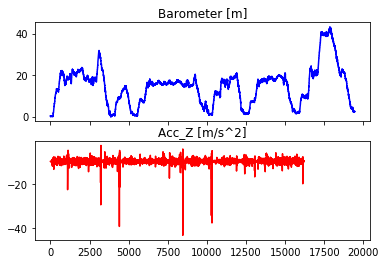

In [23]:
from matplotlib import pyplot as plt
std_dir = "/home/samuel/SpiderOak Hive/ACUASI/NASA TO6/Data Management/Example Log Files/"
f1_name = std_dir + "S1000 21Mar2018/2018-03-21-dataflash.log"
f2_name = std_dir + "SAA2 Flights April 5/flight.log"

gps = {"alt": 0}
baro = {"alt": 0}
rcout = {"motor1": 0}
imu = {"acc_z": 0}

baro_list = []
imu_list = []
gps_list = []
rcout_list = []

with open(f2_name, "r") as f2:
    for line in f2:
        values = line.split(",")
        if values[0] == "RCOU":
            m1_pwm = int(values[2])
            rcout["motor1"] = m1_pwm
            rcout_list.append(m1_pwm)
        if values[0] == "BARO":
            baro_alt = float(values[2])
            baro["alt"] = baro_alt
            baro_list.append(baro_alt)
            baro_list.append(baro_alt)
            baro_list.append(baro_alt)
        if values[0] == "GPS":
            gps_alt = float(values[9])
            gps["alt"] = gps_alt
            gps_list.append(gps_alt)
        if values[0] == "IMU":
            acc_z = float(values[7])
            imu["acc_z"] = acc_z
            imu_list.append(acc_z)
        if -18 < imu["acc_z"] < -14.5:
            print(values[1], baro["alt"], imu["acc_z"])
        
#         if (baro["alt"] !=0 and gps["alt"] != 0 and rcout["motor1"] != 0):
#             print(baro["alt"], gps["alt"], rcout["motor1"], imu["acc_z"])

# with open(f2_name, "r") as f2:
#     for line in f2:
#         values = line.split(",")
#         if values[0] == "RCOU":
#             rcout["motor1"] = values[2]
#         if values[0] == "BARO":
#             baro["alt"] = values[2]
#         if values[0] == "GPS":
#             gps["alt"] = values[9]
#         print(baro["alt"], gps["alt"], rcout["motor1"])

# baro.pop()

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
ax1.plot(baro_list, 'b')
ax2.plot(imu_list, 'r')
ax1.set_title('Barometer [m]')
ax2.set_title('Acc_Z [m/s^2]')
plt.show()


Takeoff Algorithm:

* Check average of RCOUTs for value greater than 1200 PWM
* Maintain running average of BARO altitude value
* Once 1200 PWM is triggered see if BARO is also increasing more than x% or > some values (3 m?)

If these conditions are true then set take-off flag and get current GPS location. Accelerometer data seems to be too impulse-like to be very useful and is also quite noisy, but could us a running average as well if necessary. 


In [15]:
std_dir = "/home/samuel/SpiderOak Hive/ACUASI/NASA TO6/Data Management/Example Log Files/"
f1_name = std_dir + "S1000 21Mar2018/2018-03-21-dataflash.log"
f2_name = std_dir + "SAA2 Flights April 5/flight.log"

def percent_diff(x1, x2):
    return (abs(x1 - x2)/((x1 + x2)/2.0))*100

baro1 = []
baro2 = []

baro_samples = 30

with open(f1_name, "r") as f1:
    for line in f1:
        values = line.split(",")
        if values[0] == "RCOU":
            rcout = values[2]
            
        if values[0] == "BARO":
            if len(baro1) < baro_samples:
                baro1.append(float(values[2]))
            else:
                baro_avg = sum(i for i in baro1)/baro_samples
    print(baro_avg)
                

with open(f2_name, "r") as f2:
    for line in f2:
        values = line.split(",")
        if values[0] == "RCOU":
            rcout = values[2]
            
        if values[0] == "BARO":
            # Collect 10 seconds of baro data for averaging
            if len(baro2) < baro_samples:
                baro2.append(float(values[2]))
            else:
                baro_avg = sum(i for i in baro2)/baro_samples
    print(baro_avg)

#             else:
#                 baro_current = float(values[2])
#                 baro.pop()
#                 baro.insert(0,baro_current)
#                 baro_avg = sum(i for i in baro)/10.0
#                 per_diff_num = percent_diff(baro_current, baro_avg)
#                 output = "{:.2f} | {:.2f} | {:.2f}% | {:s}".format(baro_avg, baro_current, per_diff_num, rcout)
#                 print(output)


6.026096
0.1965998522



## Determine Landing Time

For variables:
* landingTime
* landingPosLat_deg
* landingPosLon_deg
* landingPosAlt_ft


# Flight Tests

## Waypoints

A "boot cycle" is defined as the time from the aircraft powers on until it is turned off

* Create mission with 6-8 waypoints reasonably spaced apart (at least 5 seconds of flying between each point, but less than 30 seconds)
* Fly mission
    * Record arm time in Zulu
    * Record takeoff time in Zulu
    * Record landing time in Zulu
    * Record disarm time in Zulu
    * Do not make more than one takeoff or landing per boot cycle
    * Do not move the aircraft after it has been armed (reboot if you need to change it's location)
    * Do not pass Go and do not collect $200
* Post mission
    * Give Sam tlog, dataflash (binary from aircraft) and waypoint files

In [7]:
import json
from datetime import datetime

std_dir = "/home/samuel/SpiderOak Hive/ACUASI/NASA TO6/Data Management/Example Log Files/"
f1_name = std_dir + "S1000 21Mar2018/2018-03-21-dataflash.log"
f2_name = std_dir + "SAA2 Flights April 5/flight.log"

# Useful constants
SENSOR_COL = 0
SYS_TS_COL = 1
GPS_MS_COL = 3
GPS_WK_COL = 4
LAT_COL = 7
LON_COL = 8
GPS_ALT_COL = 9
BARO_ALT_COL = 1
PWM_THRESH = 1200

values = []
gps = {}
baro = {}
rad = {}
imu = {}

with open(f1_name) as f1:
    for line in f1:
        row = line.split(",")
        
        if row[0] == "GPS":
            gps["sys_ts"] = row[SYS_TS_COL]
            gps["gps_ms"] = row[GPS_MS_COL]
            gps["gps_wk"] = row[GPS_WK_COL]
            gps["lat"] = row[LAT_COL]
            gps["lon"] = row[LON_COL]
            gps["alt"] = row[GPS_ALT_COL]
            values.append(gps)
            
        elif row[0] == "IMU":
            imu["sys_ts"] = row[SYS_TS_COL]
            imu["acc_z"] = row[7]
            values.append(imu)
            
        elif row[0] == "BARO":
            baro["sys_ts"] = row[SYS_TS_COL]
            baro["alt"] = row[BARO_ALT_COL]
            values.append(baro)
            
        elif row[0] == "RAD":
            rad["sys_ts"] = row[SYS_TS_COL]
            rad["rssi_gcs"] = row[2]
            rad["rssi_ac"] = row[3]
            rad["noise_gcs"] = row[5]
            rad["noise_ac"] = row[6]
            values.append(rad)

print(values)


[{'sys_ts': ' 832743579', 'gps_ms': ' 323198600', 'gps_wk': ' 1993', 'lat': ' 64.8577146', 'lon': ' -147.8541574', 'alt': ' 183.68'}, {'sys_ts': ' 832756223', 'acc_z': ' -9.800406'}, {'sys_ts': ' 831943644', 'rssi_gcs': ' 202', 'rssi_ac': ' 205', 'noise_gcs': ' 80', 'noise_ac': ' 70'}, {'sys_ts': ' 831943644', 'rssi_gcs': ' 202', 'rssi_ac': ' 205', 'noise_gcs': ' 80', 'noise_ac': ' 70'}, {'sys_ts': ' 832744077', 'alt': ' 832744077'}, {'sys_ts': ' 832756223', 'acc_z': ' -9.800406'}, {'sys_ts': ' 832756223', 'acc_z': ' -9.800406'}, {'sys_ts': ' 832756223', 'acc_z': ' -9.800406'}, {'sys_ts': ' 832744077', 'alt': ' 832744077'}, {'sys_ts': ' 832756223', 'acc_z': ' -9.800406'}, {'sys_ts': ' 832743579', 'gps_ms': ' 323198600', 'gps_wk': ' 1993', 'lat': ' 64.8577146', 'lon': ' -147.8541574', 'alt': ' 183.68'}, {'sys_ts': ' 832756223', 'acc_z': ' -9.800406'}, {'sys_ts': ' 832744077', 'alt': ' 832744077'}, {'sys_ts': ' 832756223', 'acc_z': ' -9.800406'}, {'sys_ts': ' 832756223', 'acc_z': ' -9.80

In [1]:
std_dir = "/home/samuel/SpiderOak Hive/ACUASI/NASA TO6/Data Management/Example Log Files/"
f_name = std_dir + "SAA2 Flights April 5/flight.log"

with open(f_name, "r") as f:
    for line in f:
        row = [x.strip() for x in line.split(",")]
        if row[0] == "BARO":
            print(row[2])


0.3474275
0.2922803
0.2398904
0.39706
0.1819858
0.07169139
0.005514722
0.1378681
0.07720611
0.2150742
0.08823556
0.129596
0.2536772
0.3612143
0.3363981
0.1819858
0.1047797
0.0634193
0.2123168
0.2481625
0.3143392
0.3419128
0.4163615
0.3253686
0.3308833
0.1875006
0.1764711
0.3501849
0.2205889
0.3336407
0.2564346
0.3363981
0.4136042
0.2261036
0.1544122
0.2564346
0.1378681
0.3115818
0.297795
0.4329057
0.3198539
0.2205889
0.4053321
0.3584569
0.2647067
0.2454051
0.05238986
-0.02205889
0.1406254
0.2509199
0.2702214
0.1792285
0.2205889
0.1185665
0.465994
0.5101118
0.6341931
0.5101118
1.229783
1.607542
1.524821
1.954969
1.657174
1.897064
1.963241
1.886035
2.365816
2.542287
2.939347
3.068943
3.363981
3.603871
3.871335
3.926482
4.392477
4.701301
4.574462
4.77575
5.079059
5.17281
5.10939
5.782187
6.041378
6.35296
6.256453
6.066195
6.402593
6.151673
6.584579
6.625939
7.091933
7.439361
7.398
7.483478
7.750942
7.739913
8.418223
9.041388
8.818041
9.672823
9.419146
9.68661
9.777602
10.06437
9.932014
10

30.32821
30.57914
30.92932
30.43299
30.59568
30.55432
30.62325
30.5295
30.07454
30.32546
30.14899
29.97803
29.60579
29.79605
29.7795
29.35211
29.38244
29.20321
28.99917
28.66001
28.75652
28.81718
28.51663
28.02858
27.9045
28.22711
28.69034
27.91828
27.42471
27.52398
26.89806
26.91736
27.15725
26.86773
26.74916
25.88059
26.21975
25.64897
25.27122
25.4146
25.27122
25.21055
25.06993
25.47526
25.29052
24.86864
24.67562
24.55706
23.9725
24.13243
23.37415
22.55246
22.37323
22.51937
22.31257
22.65999
23.17838
22.96882
22.97709
23.4486
22.97433
22.92746
22.4008
22.46974
22.65448
22.43941
22.37874
22.35117
22.56073
22.58554
22.46422
22.20503
22.19951
22.3815
21.89621
22.02029
21.8383
21.94584
22.16918
22.02856
21.86036
21.7611
21.36679
21.34473
20.90907
20.21421
20.32175
20.30521
19.8723
19.59932
19.92193
19.36495
19.6269
19.27671
19.19123
18.89068
18.65906
19.07267
17.61678
18.23994
18.02211
17.98627
17.21696
17.98075
17.44307
17.32726
17.06255
17.19766
16.91917
16.60483
16.2381
16.06163
15.72

16.73167
16.29876
16.40078
15.83828
16.32909
15.93203
16.09748
16.33461
15.5267
15.88516
15.55979
15.50188
15.82174
16.14435
16.43663
16.37597
16.387
15.65905
15.80519
15.83277
15.67284
16.04233
15.72247
15.35574
15.70593
15.63975
15.64251
15.65905
15.51567
15.72799
15.76383
15.5653
15.42468
15.45501
15.44949
15.79416
15.62597
15.57909
15.36126
15.67836
15.63424
15.36402
15.47707
15.58736
15.66181
15.63148
15.67008
15.96788
15.87964
15.92928
15.92652
16.14159
15.93479
15.8824
15.92928
16.18295
15.76659
15.88791
15.72523
16.20225
15.94306
16.30152
15.97339
15.95409
15.85207
16.00373
15.97891
16.10023
15.97064
16.012
16.20225
16.06163
15.8824
16.0506
15.90997
16.24637
15.93755
16.03957
16.22983
16.10575
16.04784
16.1995
16.08369
16.41181
16.27119
16.58553
16.24361
16.44214
16.22707
16.50281
16.35115
16.20225
16.60483
16.15814
16.53865
16.38976
16.78406
16.86126
16.60483
16.84196
16.72891
16.86126
16.45317
16.90814
16.99913
17.09564
17.27211
17.10391
17.71329
17.50649
17.18939
17.57818
17

18.46053
18.26476
18.31164
18.33094
18.1848
18.353
18.66182
18.40263
18.51568
18.67009
18.83829
18.72248
18.87414
19.11403
19.14436
18.78314
18.62597
18.81623
18.88241
18.9927
19.19675
19.42837
19.47248
19.25465
18.97616
19.13333
18.86862
19.15815
18.98443
19.03958
18.70318
18.70594
18.74454
18.66182
18.54877
18.51292
18.3916
18.51292
18.39987
18.55704
18.53222
18.60667
18.46605
18.3916
18.33369
18.17377
18.12413
17.91458
17.79601
17.98351
17.50097
17.6223
17.46788
17.27211
17.59196
17.41549
17.85391
18.06623
18.17653
18.39711
18.28682
18.31991
18.20134
17.95594
17.90355
17.76843
17.92836
17.33277
17.17009
17.36035
17.16457
17.59748
17.41549
17.56163
17.65263
17.70777
17.72432
18.11311
18.21513
18.01108
17.32174
17.54785
17.73259
17.31898
17.21972
17.38792
17.08461
17.39343
17.42928
17.35207
17.34104
17.52855
17.33829
17.47064
17.52855
17.50924
17.70502
17.70226
17.59196
17.79325
17.84564
17.70777
17.86219
17.76843
17.88424
18.17377
17.69123
17.84288
17.75465
17.91733
18.14068
18.17377

In [15]:
import os
import flight_data
import saa2

rootdir = "/home/samuel/SpiderOak Hive/ACUASI/NASA TO6/Mission Data"

flights = []

for subdirs, dirs, files in os.walk(rootdir):
    if "Flight" in subdirs:
        flights.append(subdirs)

for flight in flights:
    for subdirs, dirs, files in os.walk(flight):
        for file in files:
            if file.endswith(".log"):
                name = file.strip(".log")
                 saa2.generate(name + ".log")

00000024
00000022
00000022
00000022
2018-04-23 14-02-39


In [12]:
from datetime import datetime

leap_secs = 37
gps_epoch_offset = 315964800
gps_leap_offset = leap_secs - 19

PATH1 = "/home/samuel/SpiderOak Hive/ACUASI/NASA TO6/Mission Data/SAA2"
PATH2 = "/2018-04-23/N970UA/Flight 1/00000022.log"
boot_ts_flag = 0
gps = {}

def sys_boot_time(sys_time, gps_ms, gps_wks):
    """Use GPS time and system us time to calculate boot start time as a UTC timestamp."""
    gps_ts = round(gps_ms / 1000 + gps_wks * 86400 * 7)
    utc_ts = gps_ts + gps_epoch_offset + gps_leap_offset
    sys_ts = sys_time / 1.0E6
    boot_ts = utc_ts - sys_ts
    return boot_ts


def sys_ts_converter(sys_time, boot_ts):
    """Convert system time to UTC ISO8601 timestamp."""
    unix_ts = (sys_time / 1.0E6) + boot_ts
    return datetime.utcfromtimestamp(unix_ts).isoformat(timespec="milliseconds") + "Z"

with open(PATH1 + PATH2, "r") as f:
    for line in f:
        row = [item.strip() for item in line.split(",")]
        if row[0] == "GPS":
            gps["sys_time"] = row[1]
            gps["gps_ms"] = row[3]
            gps["gps_wk"] = row[4]
            gps["lat"] = row[7]
            gps["lon"] = row[8]
            gps["alt"] = float(row[9])
            gps["speed"] = float(row[10]) # m/s
            gps["ground_course"] = row[11]
            gps["hdop"] = row[6]
            gps["num_sats"] = row[5]

            if float(row[7]) != 0 and \
               float(row[8]) != 0 and \
               float(row[1]) != 0 and \
                boot_ts_flag == 0:
                boot_ts = sys_boot_time(int(gps["sys_time"]), int(gps["gps_ms"]),
                                        int(gps["gps_wk"]))
                boot_ts_flag = 1
        if boot_ts_flag:
            timestamp = sys_ts_converter(int(row[1]), boot_ts)
#             if "21:10:27" in timestamp:
#                 print(row[1], timestamp)
            if "21:13:58" in timestamp:
                print(row[1], timestamp)
                break

First appearance of 21:10:27 (flight 1 tlog end time) is at 
954487717 2018-04-23T21:10:27.023Z